# Set Up

In [3]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib

  Using cached tensorflow-2.8.0-cp310-cp310-win_amd64.whl (438.0 MB)
     ---------------------------------------- 0.0/438.0 MB ? eta -:--:--
     ---------------------------------------- 0.1/438.0 MB 8.9 MB/s eta 0:00:50
     ---------------------------------------- 0.4/438.0 MB 4.1 MB/s eta 0:01:46
     ---------------------------------------- 1.2/438.0 MB 8.4 MB/s eta 0:00:52
     --------------------------------------- 2.1/438.0 MB 11.0 MB/s eta 0:00:40
     --------------------------------------- 2.6/438.0 MB 11.7 MB/s eta 0:00:38
     ---------------------------------------- 2.8/438.0 MB 9.9 MB/s eta 0:00:44
     --------------------------------------- 3.6/438.0 MB 11.1 MB/s eta 0:00:40
     --------------------------------------- 4.6/438.0 MB 12.1 MB/s eta 0:00:36
     --------------------------------------- 5.5/438.0 MB 13.1 MB/s eta 0:00:34
      -------------------------------------- 6.3/438.0 MB 13.9 MB/s eta 0:00:32
      -------------------------------------- 6.3/438.0 MB 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 2.8.0 which is incompatible.
tensorflow-intel 2.13.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.17.3 which is incompatible.
tensorflow-intel 2.13.0 requires tensorboard<2.14,>=2.13, but you have tensorboard 2.8.0 which is incompatible.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.7.1 which is incompatible.
tensorflow-serving-api 2.12.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.17.3 which is incompatible.
tensorflow-serving-api 2.12.1 requires tensorflow<3,>=2.12.0, but you have tensorflow 2.8.0 which is incompatible.

[notice] A new release of pip

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
plt.imshow??

In [3]:
#functional api import 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# Folder Structures

In [19]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [20]:
os.makedirs(POS_PATH, exist_ok = True)
os.makedirs(NEG_PATH, exist_ok = True)
os.makedirs(ANC_PATH, exist_ok = True)

# Collect positive and anchors

In [21]:
#Uncompress the GZ file
!tar -xf lfw.tgz

# Move the Images to data/negative

In [24]:
for directory in os.listdir('lfw'):
    directory_path = os.path.join('lfw', directory)
    for file in os.listdir(directory_path):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

# Collect Positive and Anchor Classes

In [41]:
#get unique id
import uuid

In [44]:
uuid.uuid1()

UUID('8e190681-3007-11ee-ae1f-c4bde5784b6d')

In [49]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    #resize frame
    frame = frame[100:120+250, 200:200+250, :]
    
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #unique name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write img
        cv2.imwrite(imgname, frame)
        
        
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
         #write img
         cv2.imwrite(imgname, frame)

    cv2.imshow("Image Collection", frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
#release webcam and close image show frame
cap.release()
cv2.destroyAllWindows()

In [35]:
frame.shape

(480, 640, 3)

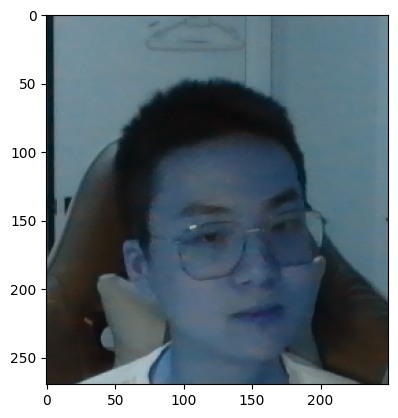

In [39]:
plt.imshow(frame[100:120+250, 200:200+250, :])

# Get Image Directories

In [50]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

In [53]:
dir_test = anchor.as_numpy_iterator()

In [55]:
dir_test.next()

b'data\\anchor\\ffee009d-3008-11ee-9149-c4bde5784b6d.jpg'

# Preprocessing

In [57]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    #Preprocessing resizing the image to be 100X100X3
    img = tf.image.resize(img, (100,100))
    #scale image to be between 0 and 1
    img = img /255.0
    return img

In [58]:
img = preprocess('data\\anchor\\ffee009d-3008-11ee-9149-c4bde5784b6d.jpg')

In [61]:
img.numpy().max()

0.8734313

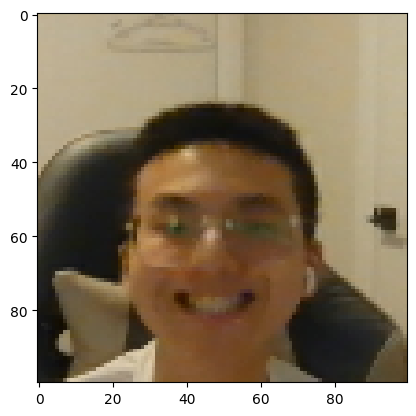

In [59]:
plt.imshow(img)

# Create Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1
# (anchor, negative) => 0,0,0,0

In [62]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [63]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [73]:
example = data.as_numpy_iterator()

In [74]:
sample = example.next()

# Build Train and Test Partition

In [69]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [76]:
res = preprocess_twin(*sample)

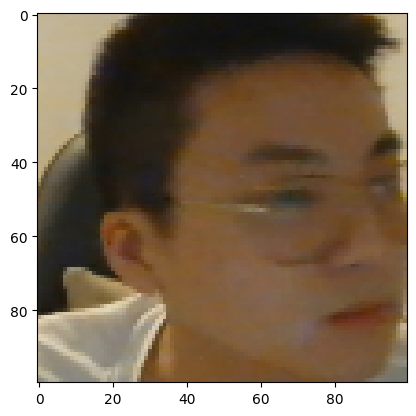

In [79]:
plt.imshow(res[0])

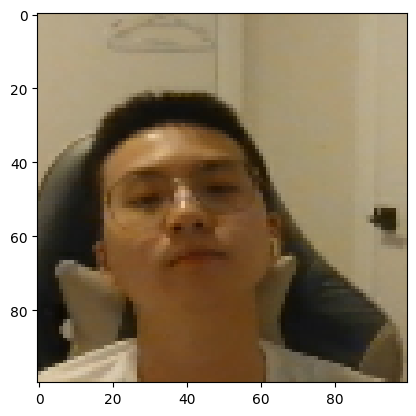

In [80]:
plt.imshow(res[1])

In [81]:
res[2]

1.0

In [82]:
#Build dataLoader Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [83]:
samples = data.as_numpy_iterator()

In [84]:
samples.next()

(array([[[0.7601961 , 0.70137256, 0.5876471 ],
         [0.7592157 , 0.70137256, 0.5896079 ],
         [0.7529412 , 0.69803923, 0.5921569 ],
         ...,
         [0.7652941 , 0.7133333 , 0.5907843 ],
         [0.76823527, 0.7133333 , 0.5996078 ],
         [0.76921564, 0.7143137 , 0.6005882 ]],
 
        [[0.7590196 , 0.69803923, 0.5907843 ],
         [0.75803924, 0.6972549 , 0.59431374],
         [0.75509804, 0.7001961 , 0.59431374],
         ...,
         [0.7586274 , 0.7119608 , 0.5838235 ],
         [0.7586274 , 0.7119608 , 0.5864706 ],
         [0.7586274 , 0.7119608 , 0.5864706 ]],
 
        [[0.7617647 , 0.6990196 , 0.59705883],
         [0.7590686 , 0.6982843 , 0.5953431 ],
         [0.75      , 0.69509804, 0.5892157 ],
         ...,
         [0.76004905, 0.7237745 , 0.60759807],
         [0.7509804 , 0.7147059 , 0.60294116],
         [0.7607843 , 0.7245098 , 0.6142157 ]],
 
        ...,
 
        [[0.09509804, 0.09901961, 0.0754902 ],
         [0.09289216, 0.09877451, 0.07426

In [86]:
len(samples.next())

3

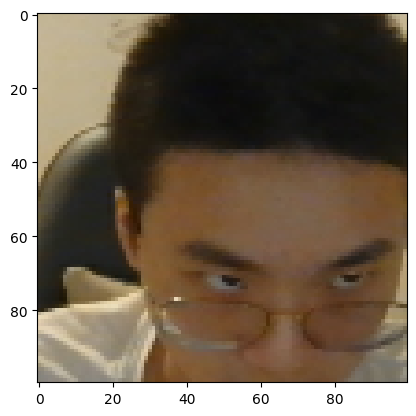

In [87]:
plt.imshow(samples.next()[0])

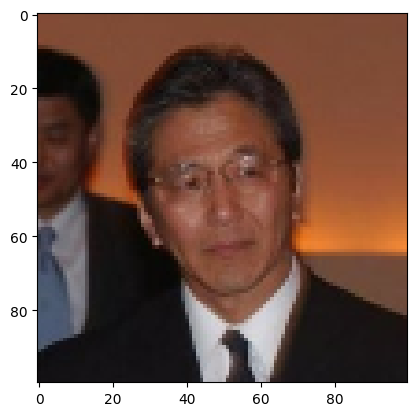

In [88]:
plt.imshow(samples.next()[1])